# IVADO-Mila Deep Learning School
# Fall 2019
# Tutorial : Convolution neural networks (CNNs)

## Authors: 

Margaux Luck <margaux.luck@rd.mila.quebec>

Jeremy Pinto <jeremy.pinto@rd.mila.quebec>

Mathieu Germain <mathieu.germain@rd.mila.quebec>

### Translation to English: 

Laurent Charlin <lcharlin@gmail.com>

## Intro

This tutorial uses concrete examples to introduce the fundamental concepts behind convolutional neural networks.

# Initialization

In [1]:
#import imp.find_module('torch')
import importlib
required_libraries = ['torch', 'torchvision', 'pillow', 'matplotlib']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

pillow unavailable


In [2]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.5.0
GPU Available: True


# The MNIST dataset
MNIST is the classic go-to **classification dataset** used in **computer vision**. It is available here: <a href="http://yann.lecun.com/exdb/mnist/">Yann LeCun's website</a>. 

Each datum is an **image of a handwritten digit**. Here are a few examples from this dataset: 

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mnist.png?raw=true)

Each image also comes with a **class label** which indicates which digit does the image correspond to. For example, the labels of the examples above are 5, 0, 4, and 1 respectively. The classes are balanced which means that all digits appear (roughly) the same number of times in the dataset.

The dataset is composed of **60 000 training examples** and **10 000 test examples**. All images have exactly the same size (**28x28 pixels** or 28 rows by 28 columns). Each pixel is represented by a number between 0 and 255 which represents its grey level (0 is white and 255 is black). Depending on the model, each image may have to be flattened (to a 784-length vector).

## Objective

Our goal is to find a model that correctly classifies these images. In particular, our model will take as input (features/covariates/independant-variables) an image and will predict its digit (label/dependant variable). This problem can be formalized as follows:

`f(image) = predicted digit`

where `f` is a function.

In this tutorial, we will consider both **multi-layer perceptrons (MLPs)** and **convolutional neural networks** as functions for solving this prediction problem. Both models take as inputs pixel intensities which will be modified using mathematical operations through the layers of the networks. Their output is a vector of size *1x10* where each entry corresponds to the (normalized) score that the input image is a particular digit. The sum over these 10 values is 1, and each score is non-negative. This is why these scores can be interpreted as probabilities. Our final prediction will be the entry with the highest score. For example, this prediction

`[0.8, 0.1, 0, 0, 0, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]`

indicates that the model assigns a score of 0.8 to class 0.

Learning implies finding the parameters of a model that will maximize the model's performance. To learn, we will start by randomly initializing the parameters of our model. Then we iterate through examples. For each example we will obtain the network's prediction, compare it with the true label, and then update the parameters of the models to obtain a better prediction. We do this until we reach some predetermined stopping criteria.

## Download the dataset and create the data loader

Before we begin training, we have to obtain the MNIST dataset. It turns out that there are built-in functions within PyTorch to do so.

### Tool box
**Note:** PyTorch comes with function to load, shuffle, and augment data.

Here is an easy way to load the data in PyTorch: 
<ol>
<li>Subclass <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset">`torch.utils.data.Dataset`</a> and add  `__getitem__` and `__len__` methods.</li>
<li>Then you can use<a href="http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader">`torch.utils.data.DataLoader`</a> to read and load the data into memory.</li>
</ol>

It is even easier for MNIST in PyTorch since there is already a subclass of "datasets" defined for it: <a href="http://pytorch.org/docs/master/torchvision/datasets.html#mnist">`torchvision.datasets.MNIST`</a>.

<a href="http://pytorch.org/docs/master/torchvision/datasets.html">Other datasets are also similarly available</a>

**Note:** <a href="http://pytorch.org/docs/master/tensors.html#torch.Tensor.view">`torch.Tensor.view()`</a> returns a new tensor with the same data as the original tensor but a different shape. For example, it can be used to flatten an image.

In [3]:
import numpy as np
import random
import torch
from torch.utils.data import sampler, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


manualSeed = 1234
use_gpu = torch.cuda.is_available()

# Fixing random seed
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_gpu:
   torch.cuda.manual_seed_all(manualSeed)

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    From: https://github.com/pytorch/vision/issues/168
    
    Parameters
    ----------
    num_samples: int
      # of desired datapoints
    start: int
      Offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


train_dataset = MNIST(root='../data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

test_dataset = MNIST(root='../data', 
                     train=False, 
                     transform=transforms.ToTensor())

train_dataset_sizes = len(train_dataset)
num_train_samples = int(0.8 * train_dataset_sizes)
num_valid_samples = train_dataset_sizes - num_train_samples
num_test_samples = len(test_dataset)

print('# of train examples: {}'.format(num_train_samples))
print('# of valid examples: {}'.format(num_valid_samples))
print('# of test examples: {}'.format(num_test_samples))

batch_size = 100

train_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(num_train_samples, 0),
                          batch_size=batch_size, 
                          shuffle=False)

valid_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(
                              num_valid_samples, num_train_samples),
                          batch_size=batch_size, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# of train examples: 48000
# of valid examples: 12000
# of test examples: 10000


Let's visualize the training data!

Inputs size: torch.Size([100, 1, 28, 28])
Classes size: torch.Size([100])


Display the first image:


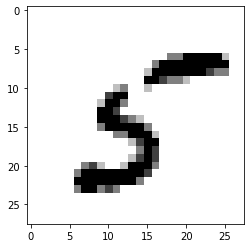

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

inputs, classes = next(iter(train_loader))

print('Inputs size: {}'.format(inputs.size()))
print('Classes size: {}'.format(classes.size()))

# Random image of the batch
img1 = 255 - inputs[np.random.randint(len(inputs))] * 255

# Plot the image
print('\n\nDisplay the first image:')
img1 = img1.numpy()[0, :, :]
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.grid(False)
plt.show()


# CPU or GPU
**Note:** <a href="http://pytorch.org/docs/master/cuda.html#module-torch.cuda">`torch.cuda`</a> is a library which can perform tensor operations using GPUs. Specifically, the library includes CUDA tensors which offer the same operations as regular tensors but instead run on GPUs, instead of CPUs.
<a href="http://pytorch.org/docs/master/cuda.html#torch.cuda.is_available">`torch.cuda.is_available()`</a> returns whether or not CUDA is available. Adding `.to("cuda:0")` to the variable identifying a CPU tensor, returns the equivalent GPU tensor.

For more information about using GPUs on colab, please refer to this [tutorial](https://colab.research.google.com/drive/1y3ZE4m-D7lPoMzsypSEXessYmjWfKGqD#scrollTo=3IEVK-KFxi5Z).


In [5]:
use_gpu = torch.cuda.is_available()

print("GPU Available: {}".format(use_gpu))

GPU Available: True


We are going to compare the performance of a CNN to the performance of a vanilla MLP. Below is a quick reminder of MLPs, the architecture of the MLP we will be using, as well as the code to train the MLP. 

# Multi-layer perceptron (MLP)
A multi-layer perceptron is a vanilla few-forward neural network. Our instanciation will take as input an image, will transform it through a series of hidden layers and then will pass it to an output layer. This output is a vector of 10 numbers where each represents the normalized score of a particular class (this is sometimes interpreted as a probability).

For example, here an MLP architecture to classify MNIST images: 
![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mlp.png?raw=true)

Whenever you are trying to solve a prediction task, the process usually goes as follows: 
<ol>
<li>Determine the network's artchitecture. This will implicitely determine the number of parameters (weights and biases) of the network.</li>
<li>Determine the cost function and the optimization method.</li>
<li>Train the weights of the network (i.e., fit the model to train data).</li>
<li>Test the network (i.e., evaluate its performance on test data).</li>
</ol>

This procedure is general and applies to all types of (deep) neural networks.

### Toolbox

Racall that a (deep) neural network can be coded by using the library <a href="http://pytorch.org/docs/master/nn.html">`torch.nn`</a>. `nn` uses <a href="http://pytorch.org/docs/master/autograd.html">`torch.autograd`</a> to instantiate and computer the gradients (of the loss function with respect to the parameters).

In [6]:
import torch.nn as nn
import copy

input_size = 784
hidden_size = 500
num_classes = 10

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, num_classes))
    
    def forward(self, x):        
        
        out = self.hidden_layer(x)
        
        out = self.output_layer(out)
        
        return out

model = MLP(input_size, hidden_size, num_classes)
# switch model to GPU
model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

learning_rate = 1e-2

criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

MLP(
  (hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=True)
  )
)


# Parameters:  648010


In [7]:
import time
from torch.autograd import Variable

model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Flatten the images
        images = images.view(-1, 28*28)

        # Zero the gradient buffer
        optimizer.zero_grad()  
        
        # Forward
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Flatten the images
        images = images.view(-1, 28*28)
        
        
        # Forward
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 2.0848
	Valid Loss: 1.5925

Epoch: 2/10
	Train Loss: 1.0058
	Valid Loss: 0.6334

Epoch: 3/10
	Train Loss: 0.5535
	Valid Loss: 0.4530

Epoch: 4/10
	Train Loss: 0.4410
	Valid Loss: 0.3867

Epoch: 5/10
	Train Loss: 0.3902
	Valid Loss: 0.3516

Epoch: 6/10
	Train Loss: 0.3600
	Valid Loss: 0.3287

Epoch: 7/10
	Train Loss: 0.3387
	Valid Loss: 0.3114

Epoch: 8/10
	Train Loss: 0.3218
	Valid Loss: 0.2974

Epoch: 9/10
	Train Loss: 0.3075
	Valid Loss: 0.2853

Epoch: 10/10
	Train Loss: 0.2949
	Valid Loss: 0.2746


Training complete in 0m 40s


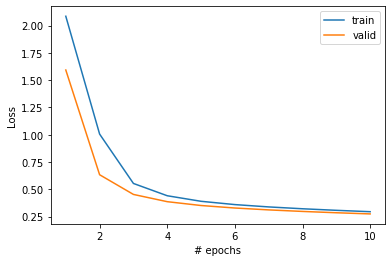

In [8]:
# Save history for later
mlp_train_loss_history = train_loss_history
mlp_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='train')
plt.plot(x, mlp_valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over test data
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # Flatten the images
    images = images.view(-1, 28*28)
    

    # Forward
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 92.00%


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


# Convolutional neural networks (CNNs)




## Concepts

We first review the basic concepts that underlie CNNs.

### Convolution

A convolution "slides" a filter *K* along image *I* to obtain an output *I*\**K*.

Here is an example of a 2D convolution:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/numerical_no_padding_no_strides.gif?raw=true)


### Filters

Filters (or kernels) are used to extract information useful to the task from their input. Filters are generally of size *n* \* *n* where *n* is usually odd. The filters are parametrized by weights, one for each of its entry, which are learned by the convolutional network.

The filter used in the previous example is:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/d7acc4aeb74d9e9cb5fb51482a302196594837fe.png?raw=true)

### Depth

We typically use *M* of filters which can be understood as the depth of the layer (see below). Note that this is different from the depth of the network (which is the number of layers). M is a hyperparameter. Here, each filter's output (blue circles) is represented as a single depth dimension on the output.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/Conv_layer.png?raw=true)

### Stride

The stride corresponds to the number of pixels the filter moves over in between each step of the convolution. The stride is measured in terms of a number of pixels. We typically use strides of 1 or 2. The larger the stride, the smaller the dimension of the output.

### Zero padding

Zero padding consists in padding (adding) a border of zeros around the input image. This can be useful to preserve the dimension from input to output.

Below is an example of a zero padding which preserves the dimensions from input to output. Here, zero padding is set to 1, stride is set to 1, and the filter has size 3x3.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/same_padding_no_strides.gif?raw=true)


### Max Pooling

In addition to convolutions, CNNs usually have pooling layers. The goal of pooling is to reduce the dimensionality of the input in-between two convolution layers to reduce the number of parameters in the network. For example, the famous LeNet CNN, uses max pooling with 2x2 filters and a stride of 2. Max pooling outputs the max value in a 2x2 region. This output is then the input of the next layer.

Here is an example of the max pooling operation:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/maxpool.jpeg?raw=true)


### Receptive Field

The receptive field is a measure of the CNNs' capacity to perceive information at different input scales. In an MLP (fully connected), the features are connected to every neuron. The receptive field of this MLP is the full image.

For CNNs, convolution operations typically imply sparse connections. In other words, each filter only has a local receptive field. However, each successive layer will have access to a slightly larger receptive field. 

Let's look at an example. Imagine a 3x3 filter with stride set to 1. In this case, the first layer's receptive field is a maximum of 3x3. However, the more layer we add the more we increase the network's receptive field. Adding a second layer with 3xe3 filters and a stride of 1, our receptive field is increased to 5x5. Adding a third 3x3 layer further increases our receptive field to 7x7.

What is the advantage of using multiple smaller successive filters instead of a single larger one? A single large filter of 7x7 implies 49 parameters. Instead 3 layers of 3x3 filters requires only 27 parameters (9 \* 3). It is therefore more efficient to use multiple successive filters and in both cases the receptive field is the same (7x7). In addition, by using multiple successive filters, we can introduce more non-linearities in the model (one after each filter).

Here the 3x3 filter (in grey) with a stride of 1 has a receptive field of 5x5 (yellow region):

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/sNBmKMKAz-yJeCuS14usSqw.png?raw=true)


### Number of dimensions

In general, for a convolutional layers with input dimensions (volume)
$W_1 * H_1 * D_1$ and hyperparameters 

* Number of filters = $K$

* Filter sizes = $F$

* Stride = $S$

* Zero Padding = $P$.

We obtain an output volume of $W_2 * H_2 * D_2$ dimensions where  

* $W_2 = (W_1 - F + 2P) / S + 1$
* $H_2 = (H1 - F + 2P) / S + 1$
* $D_2 = K$

and the total number of parameters is $(F⋅F⋅D_1)⋅K$ weights and $K$ biases.

For an in-depth analysis see [this paper](http://cs231n.github.io/convolutional-networks/)


## LeNet
CNNs have been developed to model images. They can model images more efficiently (with fewer parameters) than an equivalent MLP. LeNet is a basic CNN for classification. It comes in several versions.

We will use a "LeNet 5" to classify MNIST digit images:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/lenet5.png?raw=true)


To solve a prediction task, the process usually goes as follows (it is the same for MLPs and CNNs):
<ol>
<li>Determine the network's architecture. This will implicitly determine the number of parameters (weights and biases) of the network.</li>
<li>Determine the cost function and the optimization method.</li>
<li>Train the weights of the network (i.e., fit the model to train data).</li>
<li>Test the network (i.e., evaluate its performance on test data).</li>
</ol>


## Determining the network's architecture
### Toolbox
**Recall:** To instantiate a particular network in PyTorch, one first subclasses <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Module">`torch.nn.Module`</a> and then writes the following methods :
<ul>
<li>The `__init__` method defines the layers. </li>
<li>The `forward(input)` method returns the `output`.</li>
</ul>


For LeNet 5's '`__init__`, the following classes can be used:
<ul>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Conv2d">`torch.nn.Conv2d(in_channels, out_channels, kernel_size)`</a> applies a 2D convolution on the input channels.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d">`torch.nn.MaxPool2d(kernel_size)`</a> applies 2D max pooling on the input channels.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a> applies a linear transformation on its input: y = Ax + b.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.ReLU">`torch.nn.Relu()`</a> applies an elementwise Relu activation: Relu(x) = max(0, x).</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Softmax">`torch.nn.Softmax(dim)`</a> applies a softmax activation to an n-dimensional tensor (normalizes the exponentiated entries).</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Sequential">`torch.nn.sequential`</a> a sequential container in which to add modules in the order in which they will be constructed.</li>
</ul>

`forward(input)` successively applies the input data to the different layers defined in  `__init__`.

Finally, `model.to("cuda:0")` passes the model to an available GPU.

### Implementation

In [10]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.hidden_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc = nn.Linear(in_features=7 * 7 * 32, out_features=10)
        
    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        
        return out
        
model = LeNet5()
model = model.to(device)

print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

LeNet5(
  (hidden_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  28938


We note that LeNet4 has 28 938 parameters versus 648 010 parameters for an somewhat equivalent MLP with two hidden layers. This reduction in the number of parameters is significant. 

Here is how we calculate the number of parameters for LeNet5: 

```
1st layer: 16 filters of size 5x5 + 16 biases = 16*5*5 + 16 = 416
2nd layer: 16 * 32 filters of size 5x5 + 32 biases = 16*32*5*5 + 32 = 12 832
FC layer: 7*7*32*10 + 10 biases = 15 690
 
Total = 416 + 12 832 + 15 690 = 28 938
```

As a comparison, here is how we calculate the number of parameters of the two hidden layer MLP: 
The input flattens the 28x28 images into a vector of size 784. The second layer has 500 neurons. Each neuron requires 784 weights + 1 bias. So 500\*785 parameters. This is then fed to another layer of 500 neurons which adds 501\*500 parameters. Finally, the output layer has 10 neurons, each with 500 weights and a single bias for a total of 10\*501 parameters. 

So in total we have: 
```
500*785 + 501*500 + 10*501 = 648010
``` parameters.

In [11]:
# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

## Determine the cost function and the optimization method
### Toolbox
**Recall:** A common choice for a multi-class task are the following:
<ul>
<li>**Cost function :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. The cross entropy is often used in this context. It compares a (multivariate) distribution $p$ with a reference distribution $t$. It is minimized for $p=t$ and it is expressed mathematically by: $-\sum_j t_{ij} \log(p_{ij})$ where $p$ is the prediction, $t$ the target, $i$ are examples and $j$ the target class.</li>
<li>**Optimization method :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a> a standard stochastic gradient descent (SGD) implementation</li>
</ul>

### Implementation


In [12]:
# To complete
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Train the weights of a network
### Toolbox
**Recall:** Training a network usually involves iterating for multiple epochs over the training dataset. One epoch corresponds to one pass over the full dataset. 

The dataset is usually divided into batches. Each epoch will then receive sequentially batches. For each batch we do the following operations:
<ol>
<li>`optimizer.zero_grad()`: we clear the previously stored gradients.</li>
<li>`loss.backward()`: we evaluate the cost, the gradients, and backpropagate the gradients through the computation graph.</li>
<li>`optimizer.step()`: we update the parameters using the previously calculated gradients. For SGD, the update is: `weight = weight - learning_rate * gradient`.</li>
</ol>

### Implementation
Just fill in the blanks... Good luck!


In [13]:
model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  

        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradient buffer
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model.forward(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model.forward(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 0.9665
	Valid Loss: 0.4012

Epoch: 2/10
	Train Loss: 0.3177
	Valid Loss: 0.2666

Epoch: 3/10
	Train Loss: 0.2316
	Valid Loss: 0.1999

Epoch: 4/10
	Train Loss: 0.1823
	Valid Loss: 0.1613

Epoch: 5/10
	Train Loss: 0.1508
	Valid Loss: 0.1370

Epoch: 6/10
	Train Loss: 0.1295
	Valid Loss: 0.1207

Epoch: 7/10
	Train Loss: 0.1143
	Valid Loss: 0.1092

Epoch: 8/10
	Train Loss: 0.1032
	Valid Loss: 0.1007

Epoch: 9/10
	Train Loss: 0.0946
	Valid Loss: 0.0942

Epoch: 10/10
	Train Loss: 0.0878
	Valid Loss: 0.0890


Training complete in 0m 44s


Let's plot the training curves!

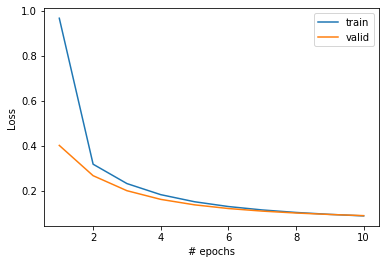

In [14]:
# Save history for later
lenet5_train_loss_history = train_loss_history
lenet5_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, lenet5_train_loss_history, label='train')
plt.plot(x, lenet5_valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can overlay the validation curves on top of the training curves for training of LeNet5:

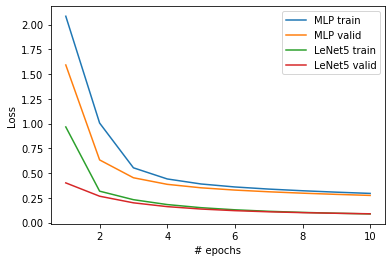

In [15]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='MLP train')
plt.plot(x, mlp_valid_loss_history, label='MLP valid')
plt.plot(x, lenet5_train_loss_history, label='LeNet5 train')
plt.plot(x, lenet5_valid_loss_history, label='LeNet5 valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test the network
### Toolbox
**Recall:** we evaluate the network's performance on test data.
### Implementation

In [16]:
# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over data.
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # No need to flatten the images here !
    

    # Forward
    outputs = model.forward(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 97.00%


The best results are obtained after 10 epochs!

---



## Methods for improving training

### Batch normalization
Batch normalization is a trick that often yields faster training. It acts as a regularizer by normalizing the inputs (by batch). Further, the operation is differentiable.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_Hiq-rLFGDpESpr8QNsJ1jg.png?raw=true)


For additional information see [article](https://arxiv.org/pdf/1502.03167v3.pdf).

### Toolbox
Batch normalization is already implemented for us. To add it to our LeNet5 network, just add another layer in `__init__`. The following class can be used:
<ul>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d">`nn.BatchNorm2d(num_features)`</a>: add batch normalisation to a 4-dimensional input encoded in a 3-dimensional tensor.</li>
</ul>

### Implement
Below, you need to add batch normalization to the original LeNet5.

In [20]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.hidden_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc = nn.Linear(in_features=7 * 7 * 32, out_features=10)
        
    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        
        return out
        
model = LeNet5()
model = model.to(device)
  
print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

LeNet5(
  (hidden_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  29034


Note that batch normalization adds parameters. Our new LeNet5 with batch normalization has 29 034 parameters (versus 28 938 for the original LeNet5 model without batch normalization).

In [21]:
# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

**The rest (i.e., the cost function, the optimizer, the training loops, and the testing procedures) remain unchanged!**

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  

        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradient buffer
        model.zero_grad()
        
        # Forward pass
        outputs = model.forward(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model.forward(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 0.3145
	Valid Loss: 0.1385

Epoch: 2/10
	Train Loss: 0.1130
	Valid Loss: 0.0951

Epoch: 3/10
	Train Loss: 0.0821
	Valid Loss: 0.0778

Epoch: 4/10
	Train Loss: 0.0671
	Valid Loss: 0.0682

Epoch: 5/10
	Train Loss: 0.0577
	Valid Loss: 0.0621

Epoch: 6/10
	Train Loss: 0.0511
	Valid Loss: 0.0580

Epoch: 7/10
	Train Loss: 0.0460
	Valid Loss: 0.0551

Epoch: 8/10
	Train Loss: 0.0420
	Valid Loss: 0.0529

Epoch: 9/10
	Train Loss: 0.0388
	Valid Loss: 0.0510

Epoch: 10/10
	Train Loss: 0.0360
	Valid Loss: 0.0493


Training complete in 0m 47s


We obtain even better results after 10 epochs!

Let's have a look at the training and validation curves:

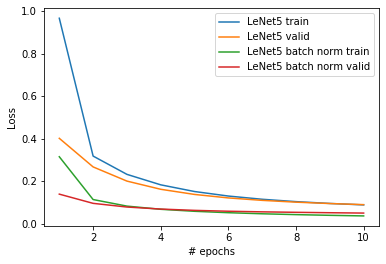

In [23]:
# Save history for later
lenet5_batchnorm_train_loss_history = train_loss_history
lenet5_batchnorm_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, lenet5_train_loss_history, label='LeNet5 train')
plt.plot(x, lenet5_valid_loss_history, label='LeNet5 valid')
plt.plot(x, lenet5_batchnorm_train_loss_history, label='LeNet5 batch norm train')
plt.plot(x, lenet5_batchnorm_valid_loss_history, label='LeNet5 batch norm valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

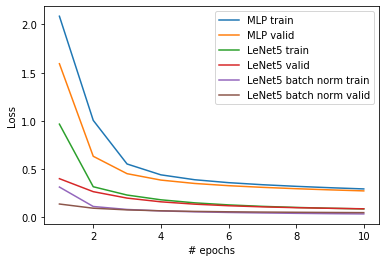

In [24]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='MLP train')
plt.plot(x, mlp_valid_loss_history, label='MLP valid')
plt.plot(x, lenet5_train_loss_history, label='LeNet5 train')
plt.plot(x, lenet5_valid_loss_history, label='LeNet5 valid')
plt.plot(x, lenet5_batchnorm_train_loss_history, label='LeNet5 batch norm train')
plt.plot(x, lenet5_batchnorm_valid_loss_history, label='LeNet5 batch norm valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Transfer Learning : finetuning a CNN
**Attribution:** this part of the tutorial is from: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. This is referred to as transfer learning.

We will now explore the finetuning of a convolutional network.

## Downloading the data and creating the data loader

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

Here are a few example images from our training dataset:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/fourmi_abeille.png?raw=true)

### Toolbox
**Recall:** an easy way to load the data in PyTorch involves: 
<ol>
<li>Sublcass<a href="http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset">`torch.utils.data.Dataset`</a> and write the `__getitem__` and `__len__` methods. (Note that these do not load the data in memory.)</li>
<li>Use<a href="http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader">`torch.utils.data.DataLoader`</a> to read and load the data into memory.</li>
</ol>

**Note:** <a href="http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets">`torchvision.datasets`</a> provides an alternative for loading data from a directory.

### Implementation

In [25]:
%%bash
## DOWNLOAD DATASET ##
if [ ! -d "hymenoptera_data" ]; then
  wget --quiet https://download.pytorch.org/tutorial/hymenoptera_data.zip
  unzip -q hymenoptera_data.zip
  rm hymenoptera_data.zip
fi

-bash: line 4: unzip: command not found


In [26]:
import os
from PIL import Image
from torchvision import datasets


def make_dataset(root, split_type):
    """
    Parameters
    ----------
    root_dir : string
    Directory with all the images.
    split_type : string
    The name of the split in {'train', 'valid'}.

    Returns
    -------
    images : dict
    Dict of images path for each classes for a specific split type.
    """

    images = {}
    root = os.path.join(root, split_type)

    for classes in sorted(os.listdir(root)):
        images[classes] = []
        path_classes = os.path.join(root, classes)

        for root_, _, fnames in sorted(os.walk(path_classes)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    item = os.path.join(root_, fname)
                    images[classes].append(item)

    return images


class HymenopteraDataset(torch.utils.data.Dataset):
    """Hymenoptera dataset."""

    def __init__(self, root_dir, split_type='train', transform=None):
        """
        Parameters
        ----------
        root_dir : string
           Directory with all the images.
        split_type : string
           The name of the split in {'train', 'valid', 'test', 'train_valid'}.
        transform : callable, optional
           Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.split_type = split_type
        self.transform = transform
        self.classes = {'ants': 0, 'bees': 1}

        imgs_ = []
        target_ = []

        if split_type == 'train':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k][:int(0.8*len(v))]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'valid':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k][int(0.8*len(v)):]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'train_valid':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'test':
            imgs = make_dataset(root_dir, 'val')
            for k, v in imgs.items():
                imgs_ += imgs[k]
                target_ += [self.classes[k]] * len(imgs_)

        self.imgs = imgs_
        self.target = np.array(target_)

    def __len__(self):
        """Get the number of image in the dataset.

        Returns
        -------
        int
           The number of images in the dataset.
        """
        return len(self.imgs)

    def __getitem__(self, index):
        """Get the items : image, target

        Parameters
        ----------
        index : int
           Index

        Returns
        -------
        img : tensor
           The image.
        target : int
           Target is class_index of the target class.
        """
        path = self.imgs[index]
        target = self.target[index]

        with open(path, 'rb') as f:
            with Image.open(f) as img:
                img.convert('RGB')

                if self.transform:
                    img = self.transform(img)

        return img, target


## Data augmentation

Data augmentation is a trick which can be used to augment the effective size of your training data. This can, in turn, help reduce overfitting. It consists in creating new data by transforming available training data. For example for images, we can resize, stretch, rotate, mirror them to obtain additional images. Here are some examples of image augmentations (right) from an original image (left): 

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_Jujct_Pt-zvdWtSFpHUp3Q.png?raw=true)


To augment your data, <a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision-transforms">`torchvision.transforms`</a> 
provides common image transformations. These transformations can be applied successively by using<a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Compose">`torchvision.transforms.Compose`</a>.

Add the following transformations using your training data:
* Random crop to resize each image to size 224x224
* Some probability of taking a mirror of the image 
* An image normalization with the following means and standard deviations: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

For the validation data, resize the image to have size 256x256, take a crop starting from the center and normalize the image with the same values as used for the training data.

In [41]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()
    ]),
}

In [42]:
# Dataset loader
data_dir = 'hymenoptera_data'

data_train = HymenopteraDataset(data_dir, 'train', data_transforms['train'])
train_loader = DataLoader(data_train, batch_size=4, shuffle=True, num_workers=0)

data_valid = HymenopteraDataset(data_dir, 'valid', data_transforms['valid'])
valid_loader = DataLoader(data_valid, batch_size=4, shuffle=False, num_workers=0)

data_test = HymenopteraDataset(data_dir, 'test', data_transforms['valid'])
test_loader = DataLoader(data_test, batch_size=4, shuffle=False, num_workers=0)

print('# images in data train: {}'.format(len(data_train)))
print('# images in data valid: {}'.format(len(data_valid)))
print('# images in data test: {}'.format(len(data_test)))

# images in data train: 193
# images in data valid: 50
# images in data test: 153


Let's have a look at our training data!

In [43]:
inputs, classes = next(iter(train_loader))

print('Classes: {}'.format(data_train.classes))
print('Inputs size: {}'.format(inputs.size()))
print('Classes size: {}'.format(classes.size()))

# Random image of the batch
idx = np.random.randint(len(inputs))
img = inputs[idx]
labels = list(data_train.classes.keys())
img_label = labels[(classes[idx])]

img = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title(img_label)
plt.grid(False)
plt.show()

TypeError: tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

In [37]:
import torchvision

def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.grid(False)
    plt.show()

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

class_names = data_train.classes
class_names = {class_names[k]: k for k in class_names.keys()}

imshow(out, title=[class_names[int(x)] for x in classes])

TypeError: tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

## Determing the network's architecture
### Toolbox

We will reuse a network pre-trained on ImageNet. To do so, we first load the pre-trained model and reinitialize its final layer (the fully connected one). Luckily, in PyTorch <a href="http://pytorch.org/docs/0.1.12/torchvision/models.html#module-torchvision.models">`torchvision.models`</a>
proposes pre-trained models on ImageNet. 

A common choice for classification problem (our setting) is to use the *ResNet18* model. For more information regarding this model, see [article](https://arxiv.org/abs/1512.03385). Useful information is also provided in the PyTorch documentation of the model:
<a href="http://pytorch.org/docs/0.1.12/torchvision/models.html#torchvision.models.resnet18">`torchvision.models.resnet18(pretrained=True)`</a>

Here is an example of a residual bloc (residual blocks are the core of residual networks such as *ResNet18*).

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/bloc_residuel.png?raw=true)


**Recall:** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a> performs a linear transformation to input data x: y = Ax + b.

### Implement

To gain insights into the value of pre-trained networks, we will first train a network from scratch and then compare it to a pre-trained version of the same model.

In [ ]:
from torchvision import models

# Load non-pre-trained resnet18 model
model = models.resnet18(pretrained=False)

# Reset last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

In [ ]:
# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

## Determine the cost function and the optimization method
### Toolbox
**Recall:** A common choice for a multi-class task are the following:
<ul>
<li>**Cost function :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. The cross entropy is often used in this context. It compares a (multivariate) distribution $p$ with a reference distribution $t$. It is minimized for $p=t$ and it is expressed mathematically by: $-\sum_j t_{ij} \log(p_{ij})$ where $p$ is the prediction,, $t$ the target, $i$ are examples and $j$ the target class.</li>
<li>**Optimization method :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a> a standard stochastic gradient descent (SGD) implementation. Here use a learning rate of $1e-3$ and a momentum of $0.9$</li>
</ul>

### Implementation

In [ ]:
criterion = ...

learning_rate = 1e-3
optimizer = ...

## Training a network
### Toolbox

**Recall:** Training a network usually involves iterating for multiple epochs over the training dataset. One epoch corresponds to one pass over the full dataset. The dataset is usually divided into batches. Each epoch will then receive sequentially batches. For each batch we do the following operations:
<ol>
<li>`optimizer.zero_grad()`: we clear the previously stored gradients.</li>
<li>`loss.backward()`: we evaluate the cost, the gradients and backpropagate the gradients through the computation graph.</li>
<li>`optimizer.step()`: we update the parameters using the previously calculated gradients. For SGD, the update is: `weight = weight - learning_rate * gradient`. Adam is similar but also adds bells and whistles (e.g., it adapts the learning rate over time for each parameter)</li>
</ol>

**Bonus:** To train deep neural networks we often use these additional tricks:
<ul>
<li>early stopping: monitors the validation error of the model and stops training if it begins to overfit (e.g., if it stops improving).</li>
<li>checkpointing: To do so, it is common to save the network's weight (you can obtain them using `model.state_dict()`) throughout training.</li>
<li>printing execution time. To do so, you can use `time.time()`.</li>
</ul>

### Implementation

In [ ]:
import time

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 25
best_acc = 0.0

train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    ...
    
    # Iterate over train data
    for images, labels in train_loader:  
        
        # put images on proper device (GPU)
        images = ...
        labels = ...

        # Zero the gradient buffer
        ...
        
        # Forward Pass
        outputs = ...
        
        loss = criterion(...)
        
        # Backward Pass
        ...
        
        # Optimize
        ...
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    ...
    
    # Iterate over valid data
    total = 0
    correct = 0
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = ...
        labels = ...
        
        # Forward
        outputs = ...
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
    
        # Statistics
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        valid_loss += loss.item()
        valid_n_iter += 1
    
    epoch_acc = 100 * correct / total
    
    # Deep copy the best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('\n\nBest valid accuracy: {:.2f}'.format(best_acc))

Let's visualize the training and validation curves:

In [ ]:
resnet18_train_loss_history = train_loss_history
resnet18_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, resnet18_train_loss_history, label='ResNet18 train')
plt.plot(x, resnet18_valid_loss_history, label='ResNet18 valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Testing the network
### Toolbox
**Recall:** we evaluate the network's performance on test data.

**Note:** Here, we do not have a test set so we will use the validation set instead (DO NOT DO THIS IN PRACTICE).

**Using the best model:** we want to reuse the weights from the best model to evaluate it on a new dataset (here validation data). These weights have been saved in the training phase in `best_model_wts`. To load them, you can use `model.load_state_dict(best_model_wts)`.

### Implementation

In [ ]:
# Load best model weights
model.load_state_dict(best_model_wts)

# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over test data
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = ...
    labels = ...
    
    # Forward
    outputs = ...
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

With pre-trained weights:

In [ ]:
from torchvision import models

# Load pre-trained resnet18 model
model = models.resnet18(pretrained=True)

# Reset last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

In [ ]:
# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

In [ ]:
criterion = ...
optimizer = ...

In [ ]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 25
best_acc = 0.0

train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    ...
    
    # Iterate over train data
    for images, labels in train_loader:  
        
        # put images on proper device (GPU)
        images = ...
        labels = ...

        # Zero the gradient buffer
        ...
        
        # Forward pass
        outputs = ...
        
        loss = ...
        
        # Backward pass
        ...
        
        # Optimize
        ...
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    total = 0
    correct = 0
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = ...
        labels = ...
        
        # Forward
        outputs = ...
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
    
        # Statistics
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        valid_loss += loss.item()
        valid_n_iter += 1
    
    epoch_acc = 100 * correct / total
    
    # Deep copy the best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('\n\nBest valid accuracy: {:.2f}'.format(best_acc))

Let's have a look at train and validation error curves:

In [ ]:
resnet18_pretrained_train_loss_history = train_loss_history
resnet18_pretrained_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, resnet18_train_loss_history, label='ResNet18 train')
plt.plot(x, resnet18_valid_loss_history, label='ResNet18 valid')
plt.plot(
      x, resnet18_pretrained_train_loss_history,
    label='ResNet18 pretrained train')
plt.plot(
      x, resnet18_pretrained_valid_loss_history,
    label='ResNet18 pretrained valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Let's test the model:

In [ ]:
# Load best model weights
model.load_state_dict(best_model_wts)

# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over test data
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = ...
    labels = ...
    
    # Forward pass
    outputs = ...
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Note that we obtain a better accuracy on the test versus the model with the weights that hadn't been trained.

# Follow-up (optional)

If you wish to know more about convolutional neural networks here are a few pointers to more advanced tasks that can be performed with these models:


## Image segmentation

While image classification is useful, it can be even more useful to determine where a particular object of interest is in the image. This is called image segmentation (it is trying to segment the image into various regions). A popular algorithm for image segmentation is [Mask R-CNN](https://arxiv.org/abs/1703.06870). Here is a tutorial that goes over the implementation of this algorithm [here].(https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb)

Here is an example of a segmented image: 

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/detection_final.png?raw=true)


## Generative models (GAN example)

A generative adversarial network (GAN) consists of two networks that are "playing" against one another. Each is trying to fool the other. The first, the generator, tries to generate realistic data (e.g., images) while the second, the discriminator, tries to determine whether the generated data is real or fake. 

Training both of these networks together can lead to the generation of high-quality data (often images). 
For example, here is an MNIST-list digit generated from a GAN trained model:
![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_nAVqFluPijpBWR2tI4gCxg.png?raw=true)

More information is available in the original [GAN paper](http://papers.nips.cc/paper/5423-generative-adversarial-nets). [Here](https://github.com/diegoalejogm/gans) is an implementation of it.



# References
Various parts of this tutorial are inspired from these other tutorials: 
<ul>
<li>https://github.com/andrewliao11/dni.pytorch/blob/master/mlp.py
<li>https://github.com/andrewliao11/dni.pytorch/blob/master/cnn.py
<li>http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
<li>http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 <li>http://cs231n.github.io/convolutional-networks/
 <li>http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#convolution-as-a-matrix-operation
</ul>